In \[157\]:

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from pylab import rcParams
    import sklearn
    from sklearn.cluster import KMeans 
    from sklearn.preprocessing import scale
    from sklearn.decomposition import PCA
    from sklearn.metrics import classification_report
    %matplotlib inline
    rcParams["figure.figsize"] =20,10

In \[158\]:

    test = pd.read_csv('Feature_label_acoustic_data_test.csv')
    train = pd.read_csv('Feature_label_acoustic_data_train.csv')

Data Preprocessing<a href="#Data-Preprocessing" class="anchor-link">¶</a>
=========================================================================

1.  remove columns with all zeros  
2.  remove highly correlated columns  
3.  use PCA to reduce to 50 features  

In \[159\]:

    def drop_high_corr(df):
        # Create correlation matrix
        corr_matrix = df.corr().abs()
        # Select upper & lower triangle of correlation matrix
        angle = corr_matrix.where((np.triu(np.ones(corr_matrix.shape), k=1) + 
                                   np.tril(np.ones(corr_matrix.shape), k=-1)).astype(bool))
        # Find features with correlation greater than 0.65
        to_drop = [column for column in angle.columns if any(angle[column] > 0.65)]
        # Drop features 
        df.drop(to_drop, axis=1, inplace=True)
        
        return df

    def preprocess(df):
        #remove columns with all zeros
        df = df.loc[:, (df != 0).any(axis=0)]
        #drop highly correlated columns
        df = drop_high_corr(df) # corr = 0.65, 126 cols left
        
        return df

In \[160\]:

    total = pd.concat([train,test], ignore_index=True)
    total = total.iloc[:, :-6]
    total = preprocess(total)

    C:\Users\353983\AppData\Local\Temp\ipykernel_17420\3017827391.py:9: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      df.drop(to_drop, axis=1, inplace=True)

In \[161\]:

    #split train & test data
    train_data = total.iloc[:78, :] #(78,50)
    test_data = total.iloc[78:, :] #(20,50)

    #reduce to 50 features
    pca = PCA(n_components=50)
    pca.fit(train_data)
    columns = ['%i' % i for i in range(50)]
    train_data = pd.DataFrame(pca.transform(train_data), columns=columns, index=train_data.index)
    test_data = pd.DataFrame(pca.transform(test_data), columns=columns, index=test_data.index)

    #labels -- using column "cluster"
    train_old_label = train.iloc[:, -5]
    test_old_label = test.iloc[:, -5]

K-Means Clustering<a href="#K-Means-Clustering" class="anchor-link">¶</a>
=========================================================================

using combined label 'cluster'  
generating 10 clusters  
plot data before and after doing K-Means Clustering  
mapping old labels to new labels:  
0 - 6  
1 - 1  
2 - 9  
3 - 3  
4 - 0  
5 - 4  
6 - 8  
7 - 5  
8 - 2  
9 - 7  

In \[162\]:

    kmeans = KMeans(n_clusters=10, init='k-means++', random_state = 5)
    kmeans.fit(train_data)
    pred = kmeans.predict(test_data)

In \[168\]:

    #relabel new labels to match old labels
    relabel = np.choose(kmeans.labels_,[4,1,8,3,5,7,0,9,6,2]).astype(np.int64)

    #plot data to compare
    colors = np.array(['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'])
    plt.subplot(1,2,1)
    plt.scatter(x=train_data['0'] ,y= train_data['1'],c = colors[train_old_label],s=50)
    plt.title("Train Before K-Means Clustering")

    plt.subplot(1,2,2)
    plt.scatter(x=train_data['0'] ,y= train_data['1'],c = colors[relabel],s=50)
    plt.title("Train After K-Means Clustering")

Out\[168\]:

    Text(0.5, 1.0, 'Train After K-Means Clustering')

<img src="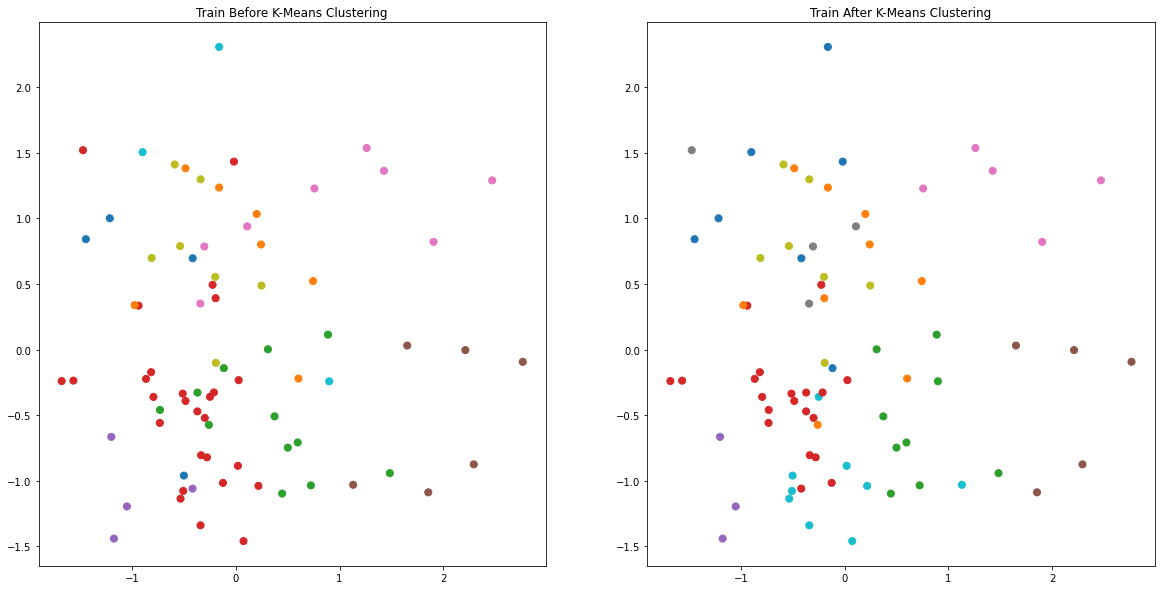%0A" class="jp-needs-light-background" />

Evaluation<a href="#Evaluation" class="anchor-link">¶</a>
=========================================================

training data:  
precision = 0.84  
F1-score = 0.76  
testing data:  
precision = 0.82  
F1-score = 0.74  

In \[169\]:

    print(classification_report(train_old_label, relabel, zero_division = 0))

                  precision    recall  f1-score   support

               0       0.43      0.75      0.55         4
               1       0.78      1.00      0.88         7
               2       0.89      0.67      0.76        12
               3       0.85      0.63      0.72        27
               4       1.00      0.75      0.86         4
               5       1.00      0.83      0.91         6
               6       1.00      0.62      0.77         8
               7       0.00      0.00      0.00         0
               8       1.00      1.00      1.00         7
               9       0.00      0.00      0.00         3

        accuracy                           0.71        78
       macro avg       0.69      0.63      0.64        78
    weighted avg       0.84      0.71      0.76        78

In \[170\]:

    relabel = np.choose(pred,[4,1,8,3,5,7,0,9,6,2]).astype(np.int64)
    print(classification_report(test_old_label, relabel, zero_division = 0))

                  precision    recall  f1-score   support

               0       0.50      1.00      0.67         1
               1       1.00      1.00      1.00         2
               2       1.00      1.00      1.00         3
               3       1.00      0.57      0.73         7
               4       1.00      1.00      1.00         1
               5       1.00      1.00      1.00         1
               6       0.00      0.00      0.00         2
               7       0.00      0.00      0.00         0
               8       1.00      1.00      1.00         2
               9       0.00      0.00      0.00         1

        accuracy                           0.70        20
       macro avg       0.65      0.66      0.64        20
    weighted avg       0.82      0.70      0.74        20

Other labels<a href="#Other-labels" class="anchor-link">¶</a>
=============================================================

If using column "HJ\_mapped"  
training data:  
precision = 0.79  
F1-score = 0.63  
testing data:  
precision = 0.75  
F1-score = 0.61  
  
If using column "LAM\_mapped"  
training data:  
precision = 0.85  
F1-score = 0.63  
testing data:  
precision = 0.85  
F1-score = 0.72  

DBSCAN<a href="#DBSCAN" class="anchor-link">¶</a>
=================================================

trying DBSCAN...  
but with some problems:  

1.  there are outliers labelled as -1, how to compare them to old labels
    and calculate accuracy?  
2.  maybe sample size too small, it is said that min\_samples should be
    at least 3 to make sense for DBSCAN,  
    but with min\_samples = 3, we cannot generate 10 clusters.  

In \[214\]:

    from sklearn.cluster import DBSCAN
    from sklearn.neighbors import NearestNeighbors
    rcParams["figure.figsize"] =20,10

    #decide eps
    neighb = NearestNeighbors(n_neighbors=2)
    nbrs=neighb.fit(train_data)
    distances,indices=nbrs.kneighbors(train_data)
    distances = np.sort(distances, axis = 0)
    distances = distances[:, 1]
    plt.plot(distances)
    plt.show()

    #DBSCAN model
    dbscan = DBSCAN(eps = 2.45, min_samples = 2).fit(train_data)
    set(dbscan.labels_)

<img src="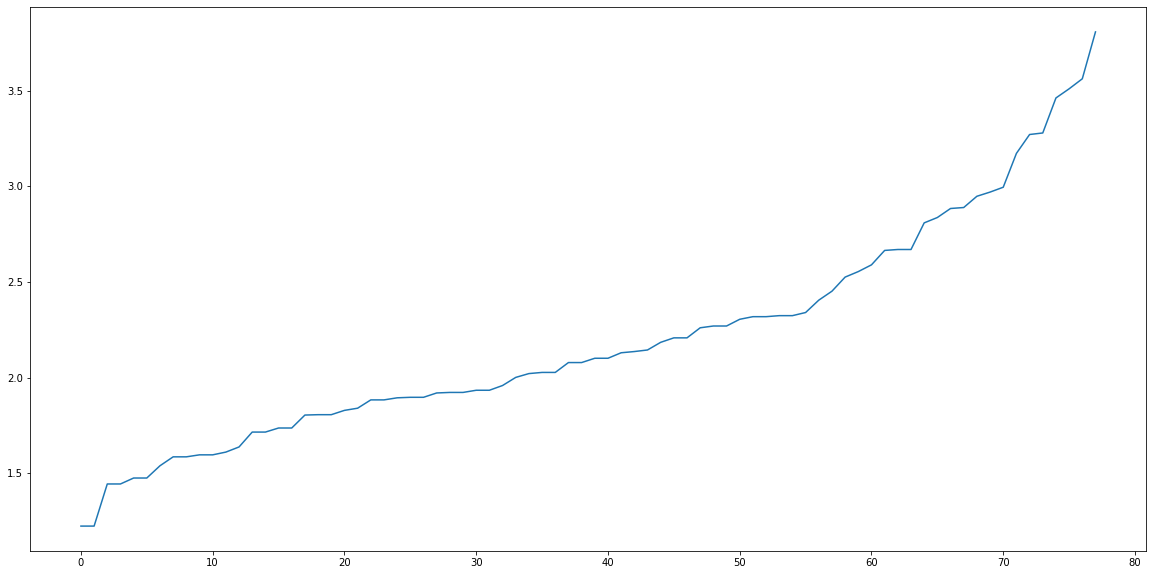%0A" class="jp-needs-light-background" />

Out\[214\]:

    {-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In \[205\]:

    #plot data to compare
    colors = np.array(['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'])
    plt.subplot(1,2,1)
    plt.scatter(x=train_data['0'] ,y= train_data['1'],c = colors[train_old_label],s=50)
    plt.title("Train Before DBSCAN")

    plt.subplot(1,2,2)
    plt.scatter(x=train_data['0'] ,y= train_data['1'],c = colors[dbscan.labels_],s=50)
    plt.title("Train After DBSCAN")

Out\[205\]:

    Text(0.5, 1.0, 'Train After DBSCAN')

<img src="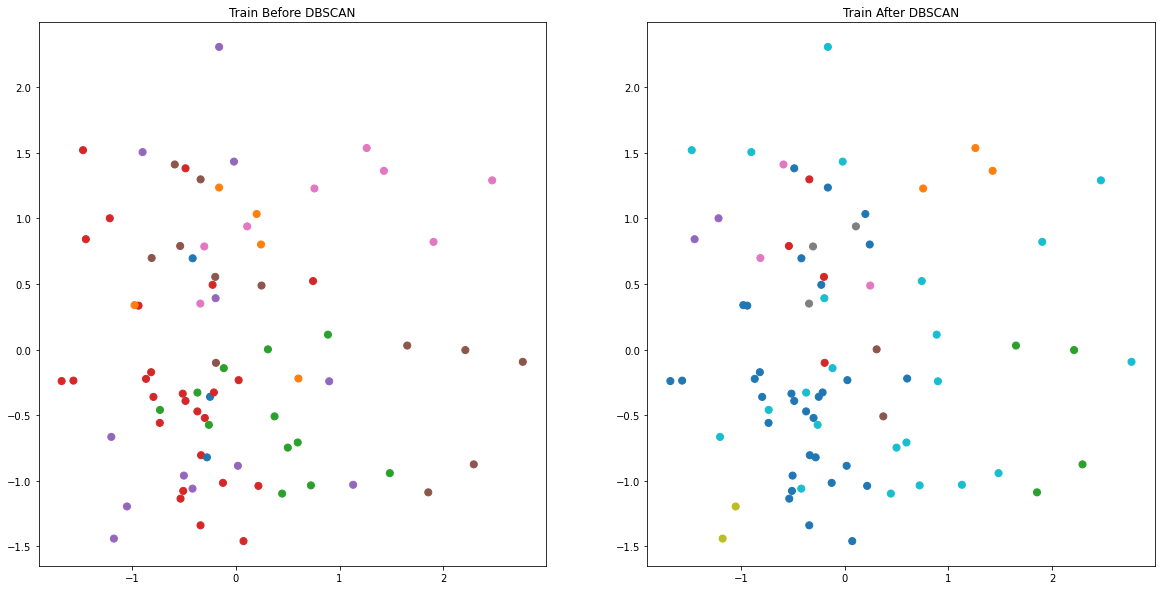%0A" class="jp-needs-light-background" />

In \[215\]:

    data = {'old': train_old_label,
            'new': dbscan.labels_}
    result = pd.DataFrame(data)
    result.to_csv('result.csv')

In \[ \]: